In [409]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DIR='C:/Users/Manohar Vemuri/Desktop/M/project/CT_SCAN'
CATEGORIES=["Normal","Kidney_stone"]
training_data=[]

def train_data():
    for categories in CATEGORIES:
        path=os.path.join(DIR,categories)
        class_num=CATEGORIES.index(categories)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(128,128))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
train_data()
random.shuffle(training_data)

0


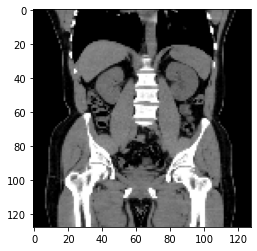

In [410]:
# KIDNEY STONE = 1
# NORMAL = 0
plt.imshow(training_data[3][0],cmap='gray')
print(training_data[3][1])

In [411]:
X=[]
y=[]
for features,labels in training_data:
    X.append(features)
    y.append(labels)
X=np.array(X)
y=np.array(y)

In [412]:
X.shape

(1609, 128, 128, 3)

In [413]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=1)
print(len(Xtrain),len(Xtest),len(ytrain),len(ytest))
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)

1448 161 1448 161


1


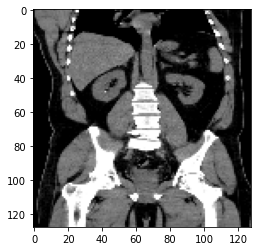

In [414]:
plt.imshow(Xtrain[6],cmap='gray')
print(ytrain[6])

In [415]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Conv2D, Flatten, Convolution2D, Activation
from keras.layers import Dropout, MaxPooling2D
from tensorflow.keras.applications import ResNet50,Xception
import pickle

In [351]:
def median_blur(img):
    mb = cv2.medianBlur(img, 1)
    res=hist(mb)
    return res
    
def hist(img):
    res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gamma_corrected = np.array(255*(res / 255) ** 2.5, dtype = 'uint8')
    thres=thresholding_img(gamma_corrected)
    return thres

def thresholding_img(img):
    ret, thresh1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    return thresh1

processed_img=[]
for img in Xtrain:
    res=median_blur(img)
    processed_img.append(res)
    
processed_img=np.array(processed_img)

In [352]:
def build_model(hp):
    model=keras.Sequential([
        keras.layers.Convolution2D(
            filters=hp.Int('conv_1_filter',min_value=32,max_value=128,step=16),
            kernel_size=hp.Choice('conv_1_kernel',values=[3,5]),
            activation='relu',
            input_shape=(128, 128, 1)
        ),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        
        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter',min_value=32,max_value=128,step=16),
            kernel_size=hp.Choice('conv_2_kernel',values=[3,5]),
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        
        
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units',min_value=32,max_value=128,step=16),
            activation='relu'
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='sigmoid')
    ]
    )
    
    
    model.compile(optimizer=keras.optimizers.RMSprop(hp.Choice('learning_rate',values=[1e-2,1e-3])),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

In [353]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
tuner_search=RandomSearch(build_model,objective='val_accuracy',max_trials=5,overwrite=True)
tuner_search.search(processed_img,ytrain,epochs=5,validation_split=0.1)

Trial 5 Complete [00h 01m 39s]
val_accuracy: 0.8689655065536499

Best val_accuracy So Far: 0.9172413945198059
Total elapsed time: 00h 09m 01s
INFO:tensorflow:Oracle triggered exit


In [354]:
model=tuner_search.get_best_models(num_models=1)[0]

In [355]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 112)       179312    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 112)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense (Dense)               (None, 80)                1

In [356]:
model.fit(processed_img,ytrain,epochs=20,batch_size=100,verbose=1,validation_split=0.1)

Epoch 1/20
14/14 [==============================] - 21s 2s/step - loss: 0.0909 - accuracy: 0.9670 - val_loss: 0.2925 - val_accuracy: 0.9379
Epoch 2/20
14/14 [==============================] - 21s 2s/step - loss: 0.0556 - accuracy: 0.9808 - val_loss: 0.2904 - val_accuracy: 0.9310
Epoch 3/20
14/14 [==============================] - 25s 2s/step - loss: 0.0318 - accuracy: 0.9893 - val_loss: 0.8874 - val_accuracy: 0.8966
Epoch 4/20
14/14 [==============================] - 30s 2s/step - loss: 0.0522 - accuracy: 0.9800 - val_loss: 0.4332 - val_accuracy: 0.9172
Epoch 5/20
14/14 [==============================] - 32s 2s/step - loss: 0.0304 - accuracy: 0.9870 - val_loss: 0.5183 - val_accuracy: 0.9310
Epoch 6/20
14/14 [==============================] - 28s 2s/step - loss: 0.0250 - accuracy: 0.9893 - val_loss: 0.3861 - val_accuracy: 0.9310
Epoch 7/20
14/14 [==============================] - 29s 2s/step - loss: 0.0178 - accuracy: 0.9939 - val_loss: 0.6060 - val_accuracy: 0.9172
Epoch 8/20
14/14 [==

In [368]:
model.save('C:/Users/Manohar Vemuri/Desktop/M/project')

INFO:tensorflow:Assets written to: C:/Users/Manohar Vemuri/Desktop/M/project\assets


In [416]:
model = keras.models.load_model('C:/Users/Manohar Vemuri/Desktop/M/project')

In [417]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 112)       179312    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 112)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense (Dense)               (None, 80)                1

In [418]:
# EVALUATING MODEL PERFORMANCE ON UNSEEN DATA

In [419]:
Xtest_processed_img=[]
for img in Xtest:
    res=median_blur(img)
    Xtest_processed_img.append(res)
    
Xtest_processed_img=np.array(Xtest_processed_img)

In [420]:
ypred=model.predict(Xtest_processed_img)

In [421]:
from sklearn.metrics import confusion_matrix
cc=confusion_matrix(ytest,(ypred>0.75)*1)
cc

array([[83,  1],
       [ 2, 75]], dtype=int64)

In [422]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest,(ypred>0.8)*1)*100

98.13664596273291

In [427]:
res=(ypred>0.75)*1
a=[]
for i in range(len(res)):
    if(res[i]==0 and res[i]!=ytest[i]):
        a.append(i)

In [428]:
print(a)
print(len(a))

[85, 124]
2


1


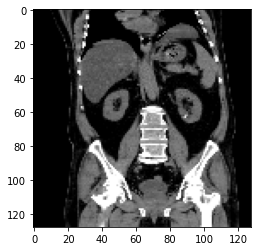

In [433]:
plt.imshow(Xtest[85],cmap='gray')
print(ytest[67])

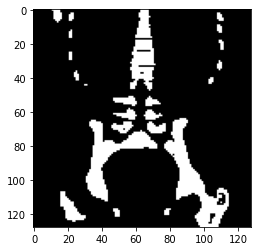

In [432]:
res=median_blur(Xtest[124])
plt.imshow(res,cmap='gray')

In [403]:
# TEST INDIVIDUAL IMAGE

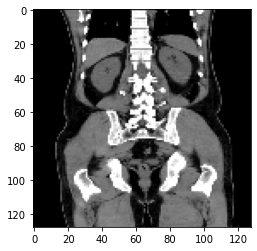

In [404]:
img_array=cv2.imread('test1.png')
new_array=cv2.resize(img_array,(128,128))
plt.imshow(new_array,cmap='gray')
res=median_blur(new_array)

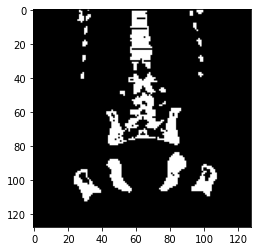

In [405]:
plt.imshow(res,cmap='gray')
plt.show()

In [406]:
res=res.reshape(-1,128,128,1)
ypred=model.predict(res)

In [407]:
(ypred>0.75)*1

array([[0]])

In [408]:
ypred

array([[3.7608531e-06]], dtype=float32)